In [1]:
'''In order to run, pull CRSP/COMPUSTAT merged securities daily data with:
tic
cusip
conm
ajexdi
prccd
trfd
'''

'In order to run, pull CRSP/COMPUSTAT merged securities daily data with:\ntic\ncusip\nconm\najexdi\nprccd\ntrfd\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
returns_data = pd.read_csv('returnsdata.csv')
# convert to datetime
returns_data['datadate'] = pd.to_datetime(returns_data['datadate'])

# ASSUMPTIONS

In [66]:
threshold = 5.00
start_date = pd.datetime(2000, 1, 1)
end_date = pd.datetime(2022, 12, 31)

delisted_loss = -100.0 #loss % when a stock is delisted during trading window
holidays = 5 #since trading periods are calculated as trading days, include margin for holidays in a 30-day trading window. 5 days is a conservative estimate.
# example: trading from 12/22 for 21 trading days will be more than 30 calendar days because of christmas, new years, and MLK day (& possible bonus weekend)

In [67]:
pdf = returns_data.copy()
print("Total rows: ", len(pdf))

# filter by date
pdf = pdf[(pdf['datadate'] >= start_date) & (pdf['datadate'] <= end_date)]
print("Rows after date filter: ", len(pdf))

# sort by cusip and datadate
pdf = pdf.sort_values(['cusip', 'datadate'])

Total rows:  4097830
Rows after date filter:  4097830


### Events Data

In [68]:
# previous price
pdf['prev_price'] = pdf.groupby('cusip')['prccd'].shift(1)
pdf['prev_price2'] = pdf.groupby('cusip')['prccd'].shift(2)

# if price less than threshold and previous price greater than or equal to threshold, then 1
pdf['event'] = np.where((pdf['prccd'] < threshold) & (pdf['prev_price'] >= threshold), 1, 0)

# events df
event_df = pdf[pdf['event'] == 1]
print("Total events at threshold: ", len(event_df))
print("Total unique cusips with events: ", len(event_df['cusip'].unique()))

Total events at threshold:  12179
Total unique cusips with events:  1168


# Returns

In [69]:
# adjusted price
pdf['adjprice'] = pdf['prccd'] * pdf['trfd'] / pdf['ajexdi']
pdf = pdf.dropna(subset=['adjprice'])

# calculate daily return
pdf['ret'] = pdf.groupby('cusip')['adjprice'].pct_change()*100

display(pdf['ret'].describe())

print("Average daily return overall of stocks: ", pdf['ret'].mean())

# average returns by cusip
company_returns = pdf.groupby('cusip')['ret'].mean()
print("Average of company average daily return: ", company_returns.mean())

count    3.619207e+06
mean     5.955193e-02
std      3.624598e+00
min     -9.718670e+01
25%     -1.118012e+00
50%      0.000000e+00
75%      1.144726e+00
max      2.191667e+03
Name: ret, dtype: float64

Average daily return overall of stocks:  0.05955193142263956
Average of company average daily return:  0.05115165659406095


# Basic Descriptive Statistics

In [70]:
# all 30-day, 60-day, 90-day, 180-day windows of return averaged
pdf['adj30day'] = pdf.groupby('cusip')['adjprice'].shift(-21)
pdf['adj60day'] = pdf.groupby('cusip')['adjprice'].shift(-42)
pdf['adj90day'] = pdf.groupby('cusip')['adjprice'].shift(-63)
pdf['adj180day'] = pdf.groupby('cusip')['adjprice'].shift(-126)

pdf['ret30day'] = (pdf['adj30day'] - pdf['adjprice']) / pdf['adjprice'] * 100
pdf['ret60day'] = (pdf['adj60day'] - pdf['adjprice']) / pdf['adjprice'] * 100
pdf['ret90day'] = (pdf['adj90day'] - pdf['adjprice']) / pdf['adjprice'] * 100
pdf['ret180day'] = (pdf['adj180day'] - pdf['adjprice']) / pdf['adjprice'] * 100

# delisted is specified loss (do not include the end of dataset since investments will be cut off during their trading window and not delisted)
pdf.loc[(pdf['adj30day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-30+holidays)), 'ret30day'] = delisted_loss
pdf.loc[(pdf['adj60day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-60+2*holidays)), 'ret60day'] = delisted_loss
pdf.loc[(pdf['adj90day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-90+3*holidays)), 'ret90day'] = delisted_loss
pdf.loc[(pdf['adj180day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-180+6*holidays)), 'ret180day'] = delisted_loss

# overall avg
avg30day = pdf['ret30day'].mean()
avg60day = pdf['ret60day'].mean()
avg90day = pdf['ret90day'].mean()
avg180day = pdf['ret180day'].mean()
std30day = pdf['ret30day'].std()
std60day = pdf['ret60day'].std()
std90day = pdf['ret90day'].std()
std180day = pdf['ret180day'].std()
stderror30day = std30day / np.sqrt(pdf['ret30day'].count())
stderror60day = std60day / np.sqrt(pdf['ret60day'].count())
stderror90day = std90day / np.sqrt(pdf['ret90day'].count())
stderror180day = std180day / np.sqrt(pdf['ret180day'].count())

# overall avg series
avg_returns = pd.Series([avg30day, avg60day, avg90day, avg180day], index=['30day', '60day', '90day', '180day'])
std_returns = pd.Series([std30day, std60day, std90day, std180day], index=['30day', '60day', '90day', '180day'])
stderror_returns = pd.Series([stderror30day, stderror60day, stderror90day, stderror180day], index=['30day', '60day', '90day', '180day'])

# confidence intervals
avg_ret_lower = avg_returns - 1.96 * stderror_returns
avg_ret_upper = avg_returns + 1.96 * stderror_returns

# create a df
avg_ret_df = pd.DataFrame({'avg_ret': avg_returns, 'std_ret': std_returns, 'stderror_ret': stderror_returns, 'avg_95%lower': avg_ret_lower, 'avg_95%upper': avg_ret_upper})
avg_ret_df


,avg_ret,std_ret,stderror_ret,avg_95%lower,avg_95%upper
30day,0.864554,16.927202,0.008909,0.847092,0.882016
60day,1.713739,24.899151,0.013122,1.688021,1.739458
90day,2.511119,30.558004,0.016128,2.479507,2.542730
180day,5.381756,49.768031,0.026379,5.330053,5.433459


In [71]:
# just events 30-day, 60-day, 90-day, 180-day windows of return averaged

# events df
event_df = pdf[pdf['event'] == 1]

# event avg
event30day = event_df['ret30day'].mean()
event60day = event_df['ret60day'].mean()
event90day = event_df['ret90day'].mean()
event180day = event_df['ret180day'].mean()
eventstd30day = event_df['ret30day'].std()
eventstd60day = event_df['ret60day'].std()
eventstd90day = event_df['ret90day'].std()
eventstd180day = event_df['ret180day'].std()
eventstderror30day = eventstd30day / np.sqrt(event_df['ret30day'].count())
eventstderror60day = eventstd60day / np.sqrt(event_df['ret60day'].count())
eventstderror90day = eventstd90day / np.sqrt(event_df['ret90day'].count())
eventstderror180day = eventstd180day / np.sqrt(event_df['ret180day'].count())

# event avg series
event_returns = pd.Series([event30day, event60day, event90day, event180day], index=['30day', '60day', '90day', '180day'])
eventstd_returns = pd.Series([eventstd30day, eventstd60day, eventstd90day, eventstd180day], index=['30day', '60day', '90day', '180day'])
eventstderror_returns = pd.Series([eventstderror30day, eventstderror60day, eventstderror90day, eventstderror180day], index=['30day', '60day', '90day', '180day'])

# confidence intervals
event_ret_lower = event_returns - 1.96 * eventstderror_returns
event_ret_upper = event_returns + 1.96 * eventstderror_returns

# create a df
event_ret_df = pd.DataFrame({'event_ret': event_returns, 'eventstd_ret': eventstd_returns, 'eventstderror_ret': eventstderror_returns, 'event_95%lower': event_ret_lower, 'event_95%upper': event_ret_upper})
event_ret_df

,event_ret,eventstd_ret,eventstderror_ret,event_95%lower,event_95%upper
30day,3.499394,24.807048,0.246352,3.016544,3.982244
60day,6.330924,35.425070,0.352214,5.640585,7.021263
90day,9.917903,43.991284,0.438142,9.059145,10.776661
180day,18.896694,66.766486,0.669105,17.585248,20.208139


In [72]:
display(avg_ret_df)
display(event_ret_df)

,avg_ret,std_ret,stderror_ret,avg_95%lower,avg_95%upper
30day,0.864554,16.927202,0.008909,0.847092,0.882016
60day,1.713739,24.899151,0.013122,1.688021,1.739458
90day,2.511119,30.558004,0.016128,2.479507,2.542730
180day,5.381756,49.768031,0.026379,5.330053,5.433459


,event_ret,eventstd_ret,eventstderror_ret,event_95%lower,event_95%upper
30day,3.499394,24.807048,0.246352,3.016544,3.982244
60day,6.330924,35.425070,0.352214,5.640585,7.021263
90day,9.917903,43.991284,0.438142,9.059145,10.776661
180day,18.896694,66.766486,0.669105,17.585248,20.208139


### T-stats

### Alternative Facts - Resampling By Month and Quarter to Find Average Return

In [73]:
# group pdf by cusip and resample datadate to monthly
monthly_pdf = pdf.groupby('cusip').resample('M', on='datadate').last()
monthly_pdf = monthly_pdf.reset_index(level=0, drop=True)


In [74]:
display(monthly_pdf['ret30day'].mean())

0.36447378500979766

In [75]:
# group pdf by cusip and resample datadate to quarterly
quarterly_pdf = pdf.groupby('cusip').resample('Q', on='datadate').last()
quarterly_pdf = quarterly_pdf.reset_index(level=0, drop=True)

In [76]:
display(quarterly_pdf['ret90day'].mean())

1.287170789090689

# Using Dates

In [77]:
event_dates = event_df['datadate'].unique()

In [78]:
# filter pdf to only include event dates
event_dates_pdf = pdf[pdf['datadate'].isin(event_dates)]

In [79]:
# create windows of event investments
event_dates_pdf['30daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(21, min_periods=1).sum().reset_index(level=0, drop=True)
event_dates_pdf['60daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(42, min_periods=1).sum().reset_index(level=0, drop=True)
event_dates_pdf['90daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(63, min_periods=1).sum().reset_index(level=0, drop=True)
event_dates_pdf['180daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(126, min_periods=1).sum().reset_index(level=0, drop=True)

### Some Cleaning Checks

In [81]:
# some non-events are below threshold but don't have a previous price. these will be excluded because it's ambiguous whether they are events or not
event_dates_pdf[(event_dates_pdf['prccd'] < threshold) & (event_dates_pdf['prev_price'].isnull())][['cusip', 'datadate', 'prccd', 'prev_price', 'prev_price2','event', '30daywindow']].head(5)

,cusip,datadate,prccd,prev_price,prev_price2,event,30daywindow
4071678,10554B104,2012-11-08,4.6499,NaN,NaN,0,0.0
1574654,16943W204,2009-03-09,3.3000,NaN,NaN,0,0.0
1810659,284902509,2003-01-23,1.5200,NaN,NaN,0,0.0
2602666,29390Q109,2001-01-10,4.1250,NaN,NaN,0,0.0
1007020,37373P105,2004-10-18,4.7100,NaN,NaN,0,0.0


In [82]:
# some non-events are below threshold but already had their event. these will be excluded because they may be in the active period of a previous event.
event_dates_pdf[(event_dates_pdf['prccd'] < threshold) & (event_dates_pdf['event']==0) & (event_dates_pdf['prev_price2']>threshold)][['cusip', 'datadate', 'prccd', 'prev_price', 'prev_price2','event', '30daywindow']].head(5)

,cusip,datadate,prccd,prev_price,prev_price2,event,30daywindow
106557,109641100,2008-11-21,3.99,4.75,5.37,0,1.0
73807,117043109,2008-10-21,4.32,4.49,5.77,0,1.0
73984,117043109,2009-01-12,4.11,4.77,5.49,0,1.0
74133,117043109,2009-05-28,4.75,4.95,5.27,0,1.0
74117,117043109,2009-06-04,4.80,4.85,5.27,0,2.0


### Cleaning: Dropping those non-events

In [83]:
event_df = event_dates_pdf[event_dates_pdf['event'] == 1]
nonevent_df30 = event_dates_pdf[event_dates_pdf['30daywindow'] == 0]
nonevent_df60 = event_dates_pdf[event_dates_pdf['60daywindow'] == 0]
nonevent_df90 = event_dates_pdf[event_dates_pdf['90daywindow'] == 0]
nonevent_df180 = event_dates_pdf[event_dates_pdf['180daywindow'] == 0]

In [91]:
all30ret = nonevent_df30.ret30day.mean()
all60ret = nonevent_df60.ret60day.mean()
all90ret = nonevent_df90.ret90day.mean()
all180ret = nonevent_df180.ret180day.mean()

all30std = nonevent_df30.ret30day.std()
all60std = nonevent_df60.ret60day.std()
all90std = nonevent_df90.ret90day.std()
all180std = nonevent_df180.ret180day.std()

all30stderror = all30std / np.sqrt(nonevent_df30.ret30day.count())
all60stderror = all60std / np.sqrt(nonevent_df60.ret60day.count())
all90stderror = all90std / np.sqrt(nonevent_df90.ret90day.count())
all180stderror = all180std / np.sqrt(nonevent_df180.ret180day.count())

all30lower = all30ret - 1.96 * all30stderror
all30upper = all30ret + 1.96 * all30stderror

all60lower = all60ret - 1.96 * all60stderror
all60upper = all60ret + 1.96 * all60stderror

all90lower = all90ret - 1.96 * all90stderror
all90upper = all90ret + 1.96 * all90stderror

all180lower = all180ret - 1.96 * all180stderror
all180upper = all180ret + 1.96 * all180stderror

all_returns = pd.Series([all30ret, all60ret, all90ret, all180ret], index=['30day', '60day', '90day', '180day'])
allstd_returns = pd.Series([all30std, all60std, all90std, all180std], index=['30day', '60day', '90day', '180day'])
allstderror_returns = pd.Series([all30stderror, all60stderror, all90stderror, all180stderror], index=['30day', '60day', '90day', '180day'])
all_lower = pd.Series([all30lower, all60lower, all90lower, all180lower], index=['30day', '60day', '90day', '180day'])
all_upper = pd.Series([all30upper, all60upper, all90upper, all180upper], index=['30day', '60day', '90day', '180day'])

all_avg_ret_df = pd.DataFrame({'nonevent_returns': all_returns, 'nonevent_std': allstd_returns, 'nonevent_stderror': allstderror_returns, 'nonevent_95%lower': all_lower, 'nonevent_95%upper': all_upper})

all_avg_ret_df


,nonevent_returns,nonevent_std,nonevent_stderror,nonevent_95%lower,nonevent_95%upper
30day,0.883389,16.976749,0.011245,0.861350,0.905429
60day,1.531265,24.564415,0.016555,1.498817,1.563713
90day,2.335103,29.717799,0.020328,2.295261,2.374945
180day,3.323979,42.389441,0.030101,3.264981,3.382976


In [92]:
### this assumes you are doubling down on multiple events.
### essentially if a stock drops below the threshold multiple times, you are longing it again each time it drops.
event30ret = event_df.ret30day.mean()
event60ret = event_df.ret60day.mean()
event90ret = event_df.ret90day.mean()
event180ret = event_df.ret180day.mean()

event30std = event_df.ret30day.std()
event60std = event_df.ret60day.std()
event90std = event_df.ret90day.std()
event180std = event_df.ret180day.std()

event30stderror = event30std / np.sqrt(event_df.ret30day.count())
event60stderror = event60std / np.sqrt(event_df.ret60day.count())
event90stderror = event90std / np.sqrt(event_df.ret90day.count())
event180stderror = event180std / np.sqrt(event_df.ret180day.count())

event30lower = event30ret - 1.96 * event30stderror
event30upper = event30ret + 1.96 * event30stderror

event60lower = event60ret - 1.96 * event60stderror
event60upper = event60ret + 1.96 * event60stderror

event90lower = event90ret - 1.96 * event90stderror
event90upper = event90ret + 1.96 * event90stderror

event180lower = event180ret - 1.96 * event180stderror
event180upper = event180ret + 1.96 * event180stderror

event_returns = pd.Series([event30ret, event60ret, event90ret, event180ret], index=['30day', '60day', '90day', '180day'])
eventstd_returns = pd.Series([event30std, event60std, event90std, event180std], index=['30day', '60day', '90day', '180day'])
eventstderror_returns = pd.Series([event30stderror, event60stderror, event90stderror, event180stderror], index=['30day', '60day', '90day', '180day'])
event_lower = pd.Series([event30lower, event60lower, event90lower, event180lower], index=['30day', '60day', '90day', '180day'])
event_upper = pd.Series([event30upper, event60upper, event90upper, event180upper], index=['30day', '60day', '90day', '180day'])

event_avg_ret_df = pd.DataFrame({'event_returns': event_returns, 'event_std': eventstd_returns, 'event_stderror': eventstderror_returns, 'event_95%lower': event_lower, 'event_95%upper': event_upper})

event_avg_ret_df

,event_returns,event_std,event_stderror,event_95%lower,event_95%upper
30day,3.499394,24.807048,0.246352,3.016544,3.982244
60day,6.330924,35.425070,0.352214,5.640585,7.021263
90day,9.917903,43.991284,0.438142,9.059145,10.776661
180day,18.896694,66.766486,0.669105,17.585248,20.208139


In [130]:
### this assumes you only invest in an event stock once, and then hold it for the duration of the event with no reinvesting.
### essentially if a stock drops below the threshold multiple times, you leave it alone if it's already longed.

event_df30 = event_df[event_df['30daywindow'] == 1]
event_df60 = event_df[event_df['60daywindow'] == 1]
event_df90 = event_df[event_df['90daywindow'] == 1]
event_df180 = event_df[event_df['180daywindow'] == 1]

event30ret30 = event_df30.ret30day.mean()
event60ret60 = event_df60.ret60day.mean()
event90ret90 = event_df90.ret90day.mean()
event180ret180 = event_df180.ret180day.mean()

event30std30 = event_df30.ret30day.std()
event60std60 = event_df60.ret60day.std()
event90std90 = event_df90.ret90day.std()
event180std180 = event_df180.ret180day.std()

event30stderror30 = event30std30 / np.sqrt(event_df30.ret30day.count())
event60stderror60 = event60std60 / np.sqrt(event_df60.ret60day.count())
event90stderror90 = event90std90 / np.sqrt(event_df90.ret90day.count())
event180stderror180 = event180std180 / np.sqrt(event_df180.ret180day.count())

event30lower30 = event30ret30 - 1.96 * event30stderror30
event30upper30 = event30ret30 + 1.96 * event30stderror30

event60lower60 = event60ret60 - 1.96 * event60stderror60
event60upper60 = event60ret60 + 1.96 * event60stderror60

event90lower90 = event90ret90 - 1.96 * event90stderror90
event90upper90 = event90ret90 + 1.96 * event90stderror90

event180lower180 = event180ret180 - 1.96 * event180stderror180
event180upper180 = event180ret180 + 1.96 * event180stderror180

even_returns_closed = pd.Series([event30ret30, event60ret60, event90ret90, event180ret180], index=['30day', '60day', '90day', '180day'])
eventstd_returns_closed = pd.Series([event30std30, event60std60, event90std90, event180std180], index=['30day', '60day', '90day', '180day'])
eventstderror_returns_closed = pd.Series([event30stderror30, event60stderror60, event90stderror90, event180stderror180], index=['30day', '60day', '90day', '180day'])
event_lower_closed = pd.Series([event30lower30, event60lower60, event90lower90, event180lower180], index=['30day', '60day', '90day', '180day'])
event_upper_closed = pd.Series([event30upper30, event60upper60, event90upper90, event180upper180], index=['30day', '60day', '90day', '180day'])

event_avg_ret_df_closed = pd.DataFrame({'event_returns': even_returns_closed, 'event_std': eventstd_returns_closed, 'event_stderror': eventstderror_returns_closed, 'event_95%lower': event_lower_closed, 'event_95%upper': event_upper_closed})

event_avg_ret_df_closed

,event_returns,event_std,event_stderror,event_95%lower,event_95%upper
30day,4.309708,27.049545,0.423062,3.480506,5.138911
60day,8.273838,39.741797,0.715169,6.872106,9.675570
90day,15.944053,53.327567,1.043434,13.898922,17.989185
180day,22.133117,72.711318,1.615408,18.966916,25.299317


In [131]:
display(all_avg_ret_df)
display(event_avg_ret_df)
display(event_avg_ret_df_closed)

,nonevent_returns,nonevent_std,nonevent_stderror,nonevent_95%lower,nonevent_95%upper
30day,0.883389,16.976749,0.011245,0.861350,0.905429
60day,1.531265,24.564415,0.016555,1.498817,1.563713
90day,2.335103,29.717799,0.020328,2.295261,2.374945
180day,3.323979,42.389441,0.030101,3.264981,3.382976


,event_returns,event_std,event_stderror,event_95%lower,event_95%upper
30day,3.499394,24.807048,0.246352,3.016544,3.982244
60day,6.330924,35.425070,0.352214,5.640585,7.021263
90day,9.917903,43.991284,0.438142,9.059145,10.776661
180day,18.896694,66.766486,0.669105,17.585248,20.208139


,event_returns,event_std,event_stderror,event_95%lower,event_95%upper
30day,4.309708,27.049545,0.423062,3.480506,5.138911
60day,8.273838,39.741797,0.715169,6.872106,9.675570
90day,15.944053,53.327567,1.043434,13.898922,17.989185
180day,22.133117,72.711318,1.615408,18.966916,25.299317


In [135]:
print('With reinvesting, the events are: ', len(event_df))
print('With no reinvesting, the 30-day events are: ', len(event_df30))
print('With no reinvesting, the 60-day events are: ', len(event_df60))
print('With no reinvesting, the 90-day events are: ', len(event_df90))
print('With no reinvesting, the 180-day events are: ', len(event_df180))

With reinvesting, the events are:  10179
With no reinvesting, the 30-day events are:  4102
With no reinvesting, the 60-day events are:  3104
With no reinvesting, the 90-day events are:  2629
With no reinvesting, the 180-day events are:  2059


In [142]:
## double check 30-day:

# if an event is a novel event in the 30-day window, it will be 1.0
display(event_df[event_df['event'] == 1]['30daywindow'].value_counts())
# the output matches the no reinvesting count for 30-day novel events

# the sum is the total times an event occurred in general, meaning a 2nd or 3rd event in a running 30-day window will be counted as a fresh event
display(event_df[event_df['event'] == 1]['30daywindow'].value_counts().sum())
# the output matches the reinvesting count for any event that occurs whenever

1.0     4102
2.0     2971
3.0     1743
4.0      889
5.0      322
6.0       97
7.0       35
8.0        9
9.0        4
10.0       3
11.0       2
12.0       2
Name: 30daywindow, dtype: int64

10179

### Some Double-Checking

In [88]:
# see min - delistings are total loss
event_df['ret180day'].describe()

count    9957.000000
mean       18.896694
std        66.766486
min      -100.000000
25%       -16.929850
50%         8.280255
75%        41.237113
max      1783.162218
Name: ret180day, dtype: float64

In [89]:
# see min - delistings are total loss
nonevent_df180['ret180day'].describe()

count    1.983182e+06
mean     3.323979e+00
std      4.238944e+01
min     -1.000000e+02
25%     -1.378966e+01
50%      2.619151e+00
75%      1.739972e+01
max      2.547059e+03
Name: ret180day, dtype: float64

## Checking For Outliers

In [144]:
# calculate event_df['ret180day'] outliers
Q1 = event_df['ret180day'].quantile(0.25)
Q3 = event_df['ret180day'].quantile(0.75)
Q90 = event_df['ret180day'].quantile(0.90)
Q99 = event_df['ret180day'].quantile(0.99)
Q999 = event_df['ret180day'].quantile(0.999)

print('event')
display(Q1)
display(Q3)
display(Q90)
display(Q99)
display(Q999)

# calculate nonevent_df180['ret180day'] outliers
Q1non = nonevent_df180['ret180day'].quantile(0.25)
Q3non = nonevent_df180['ret180day'].quantile(0.75)
Q90non = nonevent_df180['ret180day'].quantile(0.90)
Q99non = nonevent_df180['ret180day'].quantile(0.99)
Q999non = nonevent_df180['ret180day'].quantile(0.999)
Q9999non = nonevent_df180['ret180day'].quantile(0.9999)

print('nonevent')
display(Q1non)
display(Q3non)
display(Q90non)
display(Q99non)
display(Q999non)

event


-16.929849683228763

41.23711340206187

88.83581992727406

237.95585535064012

597.4625709080104

nonevent


-13.789660064223952

17.39972086718156

38.60041929606736

125.03311548669537

345.42119164621636

In [146]:
event_outliers = event_df[event_df['ret180day'] > Q999]
nonevent_outliers = nonevent_df180[nonevent_df180['ret180day'] > Q9999non]

event_outliers_cusip = event_outliers['cusip'].unique()
nonevent_outliers_cusip = nonevent_outliers['cusip'].unique()

In [147]:
display(len(event_outliers_cusip))
display(len(nonevent_outliers_cusip))

5

13

# Event Outliers

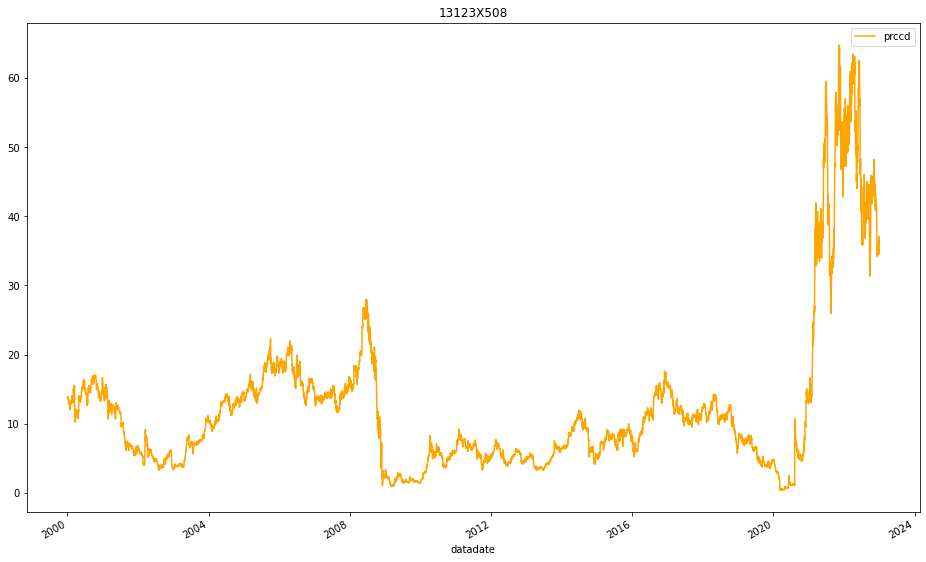

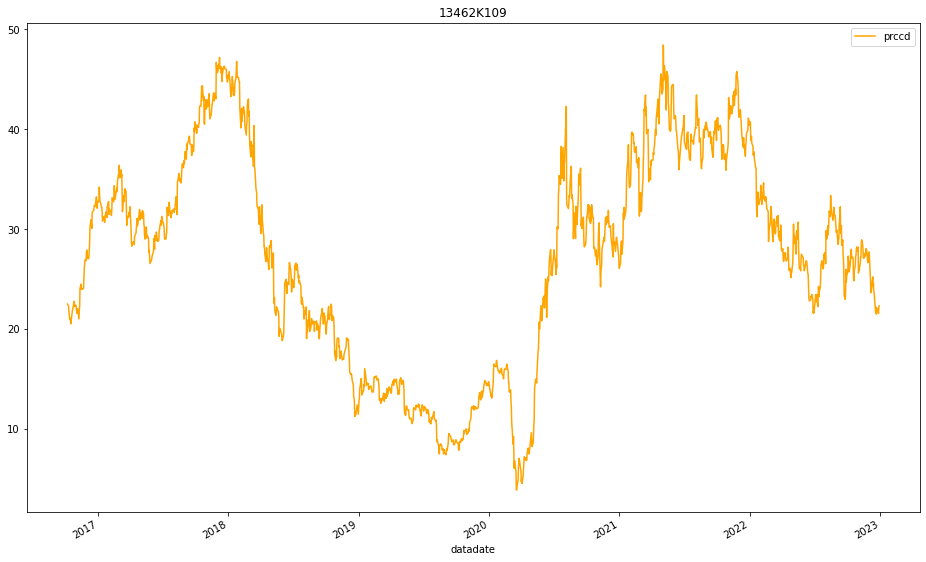

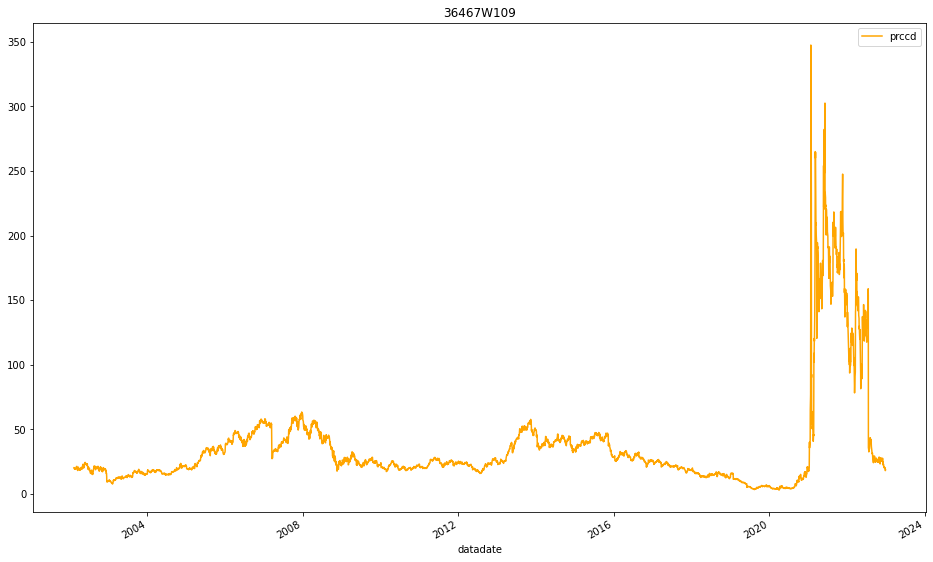

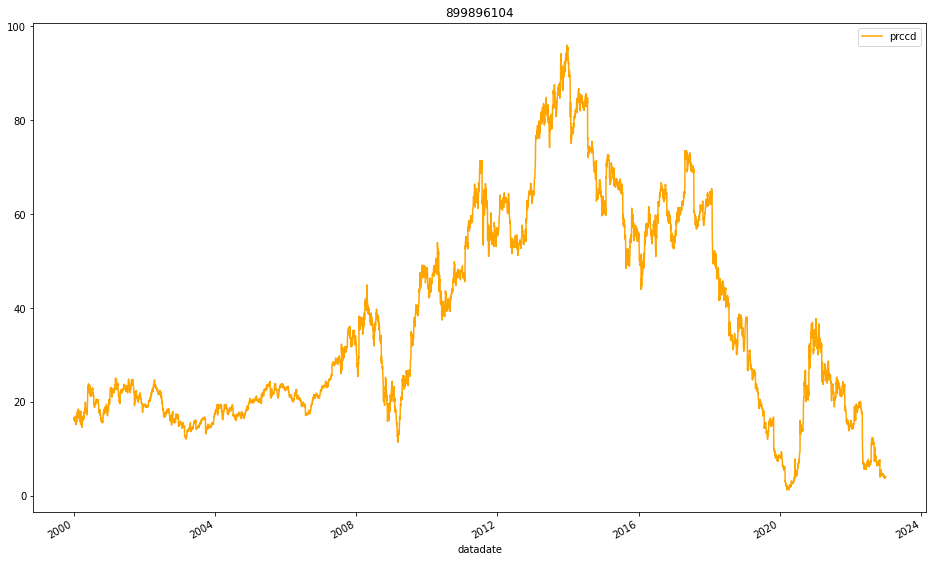

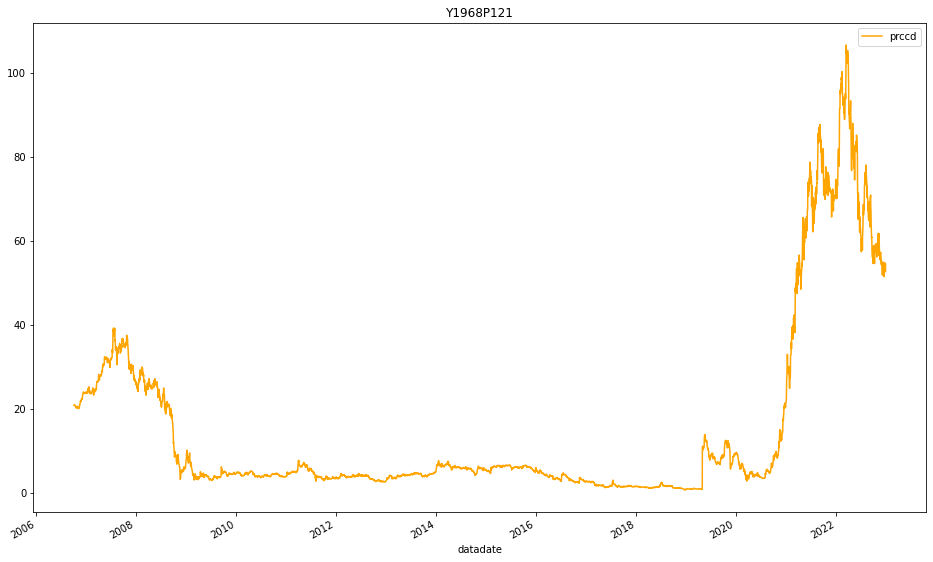

In [148]:
for i in event_outliers_cusip:
    #plot adjprice of event outliers
    pdf[pdf['cusip'] == i].plot(x='datadate', y=['prccd'], title=i, figsize = (16,10), color='orange')

# Nonevent Outliers

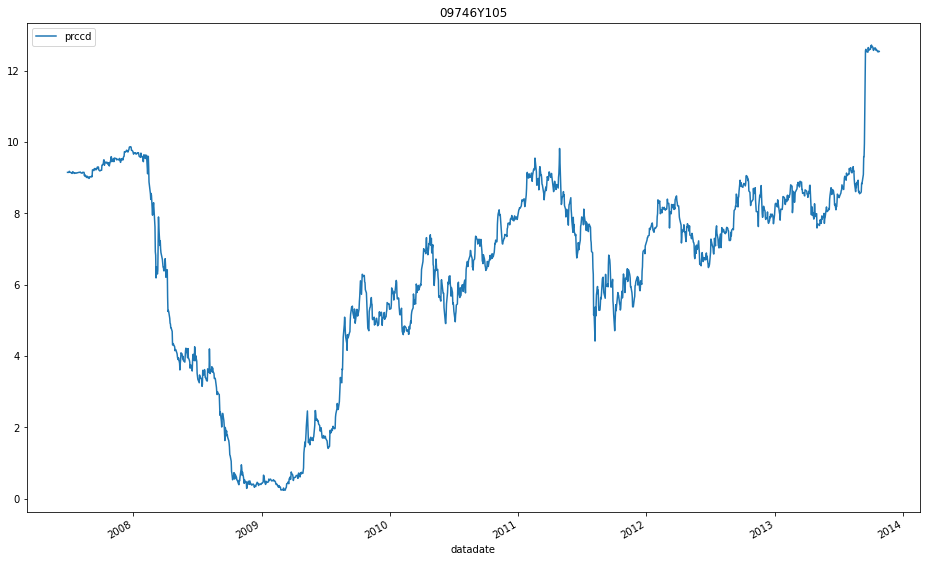

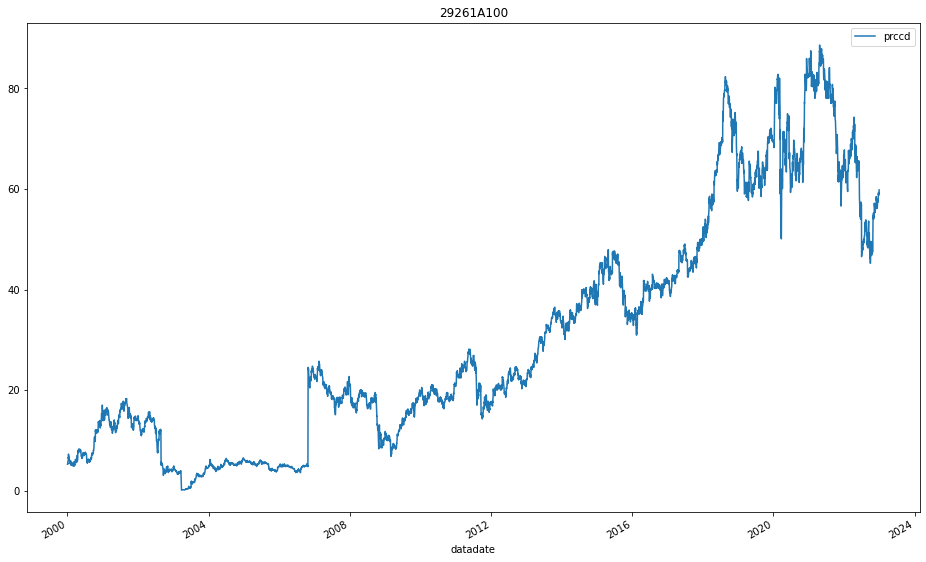

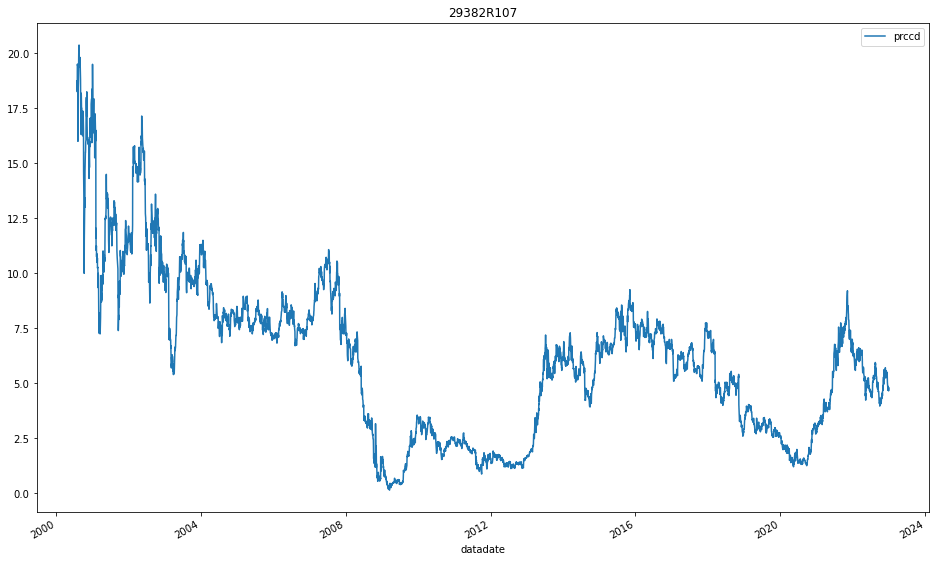

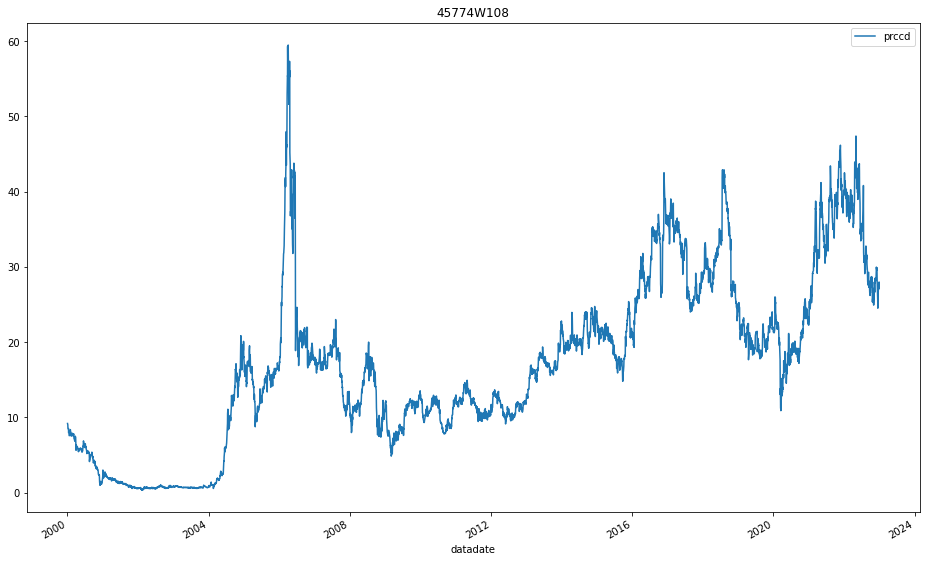

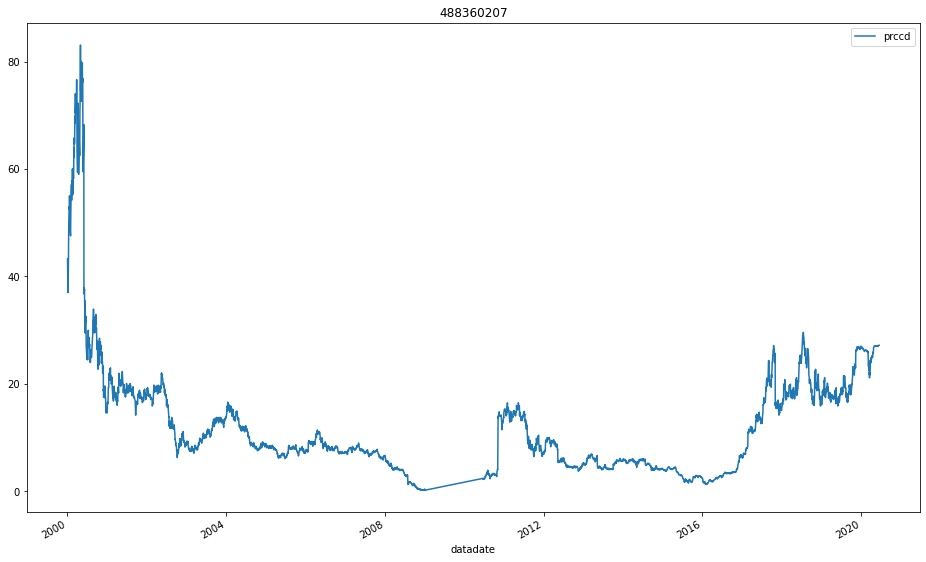

In [150]:
for i in nonevent_outliers_cusip[:5]:
    #plot adjprice of nonevent outliers
    pdf[pdf['cusip'] == i].plot(x='datadate', y=['prccd'], title=i, figsize = (16,10))